In [46]:
#This is to use the 216paper env and pymatgen4.5.7 with python3.5, I really hate hwo pymatgen updated!!!!!
#and matplotlib 2.0.1
from pymatgen.io.vasp.outputs import Vasprun
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from matplotlib import gridspec
import re
from pymatgen.core.periodic_table import Element
import matplotlib.ticker as ticker
matplotlib.rcParams.update({'font.size': 20})

In [47]:
def get_k_dist(kpoints):
    dist = np.zeros(len(kpoints))
    for i in range(len(kpoints)-1):
        dist[i+1]=dist[i]+np.linalg.norm(kpoints[i]-kpoints[i+1])
    return dist
    

In [48]:
def get_special_k(kpoints):
    k_index = [0]
    for i in range(len(kpoints)-1):
        if np.linalg.norm(kpoints[i]-kpoints[i+1]) < 1e-8:
            k_index.append(i)
    k_index.append(len(kpoints)-1)
    return get_k_dist(kpoints)[k_index]

In [49]:
def get_k_label(kpoints, labels):
    k_index = [0]
    for i in range(len(kpoints)-1):
        if np.linalg.norm(kpoints[i]-kpoints[i+1]) < 1e-8:
            k_index.append(i)
    k_index.append(len(kpoints)-1)
    return labels[k_index]

In [50]:
def scissor_shift(energy, scissor):
    import copy
    energy_copy = copy.deepcopy(energy)
    for i in range(energy.shape[0]):
        if energy[i] > 0:
            energy_copy[i] = energy[i]+scissor
    return energy_copy

In [51]:
##This is just for bands with up spin(in a spin-polarized calculation for non-magnetic materials)
def draw_bands(bs, ylim):
    kpoints = [i.cart_coords for i in bs.kpoints]
    kpoints_dist = get_k_dist(kpoints)
    label = get_k_label(kpoints, np.array([i.label for i in bs.kpoints]))
    bands = [bs.bands[i] for i in bs.bands]
    bands_up = np.array(bands[0]) - bs.get_vbm()['energy']
    print(bands_up.shape)
    for i in range(len(bands_up)):
        plt.plot(kpoints_dist, scissor_shift(bands_up[i], scissor),'b')
    plt.plot([0, kpoints_dist[-1]], [0, 0], 'k--')
    for i in get_special_k(kpoints):
        plt.plot([i, i], ylim, 'k')
    plt.xlim([0, kpoints_dist[-1]])
    plt.ylim(ylim)
    label_loc = get_special_k(kpoints)
    label[label=='\\Gamma'] = r'$\Gamma$'
    plt.xticks(label_loc, label)
    plt.ylabel('Energy (eV)')
    

In [52]:
## This is just for SOC bands ksplit calculations
def draw_bands_ksplit(kpoints_obj, bands, vbm, ylim):
    kpoints = [i.cart_coords for i in kpoints_obj]
    kpoints_dist = get_k_dist(kpoints)
    label = get_k_label(kpoints, np.array([i.label for i in kpoints_obj]))
    bands = bands - vbm
    for i in range(len(bands)):
        plt.plot(kpoints_dist, bands[i],'b')
    plt.plot([0, kpoints_dist[-1]], [0, 0], 'k--')
    for i in get_special_k(kpoints):
        plt.plot([i, i], ylim, 'k')
    plt.xlim([0, kpoints_dist[-1]])
    plt.ylim(ylim)
    label_loc = get_special_k(kpoints)
    label[label=='\\Gamma'] = r'$\Gamma$'
    plt.xticks(label_loc, label)
    plt.ylabel('Energy (eV)')

In [53]:
#draw total DOS only
def draw_total_dos(v, xlim, ylim, scissor):
    vbm = v.eigenvalue_band_properties[2]
    comp_dos = v.complete_dos
    elements = [i for i in comp_dos.get_element_dos()]
    for element in elements:
        el_dos = comp_dos.get_element_dos()[element]
        plt.plot(el_dos.get_densities(), scissor_shift(el_dos.energies-vbm, scissor), label = element)
        
    tdos = v.tdos
    plt.plot(tdos.get_densities(), scissor_shift(el_dos.energies-vbm, scissor), 'k', label = 'Total')

    plt.legend(prop={'size': 15})
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.plot(xlim, [0, 0], 'k--')
    plt.xlabel('DOS (states/eV)')
    
    #plt.yticks([])



In [54]:
#draw pDOS only
def draw_pdos(v, element_str, xlim, ylim, scissor):
    vbm = v.eigenvalue_band_properties[2]
    comp_dos = v.complete_dos
    elements = [i for i in comp_dos.get_element_dos()]
    #element = elements[element_no]
    element = Element(element_str)
    pdos = comp_dos.get_element_spd_dos(element)

    orbitals = [i for i in pdos]
    for o in orbitals:
        p_dos = pdos[o]
        plt.plot(p_dos.get_densities(), scissor_shift(p_dos.energies-vbm, scissor), label = element.symbol + '-' + o.name)

    plt.legend(prop={'size': 15})
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.plot(xlim, [0, 0], 'k--')
    plt.xlabel('DOS (states/eV)')
    plt.yticks([])



//anaconda/envs/216paper/lib/python3.5/site-packages/pymatgen/io/vasp/outputs.py:814: UserWarning: No POTCAR file with matching TITEL fields was found in /Users/yao/Google Drive/data/2116/PBE_SOC_BS/Rb2In1In1Br6
  " was found in {}".format(os.path.abspath(p)))


(119, 60)


//anaconda/envs/216paper/lib/python3.5/site-packages/pymatgen/io/vasp/outputs.py:814: UserWarning: No POTCAR file with matching TITEL fields was found in /Users/yao/Google Drive/data/2116/PBE_SOC/Rb2In1In1Br6
  " was found in {}".format(os.path.abspath(p)))


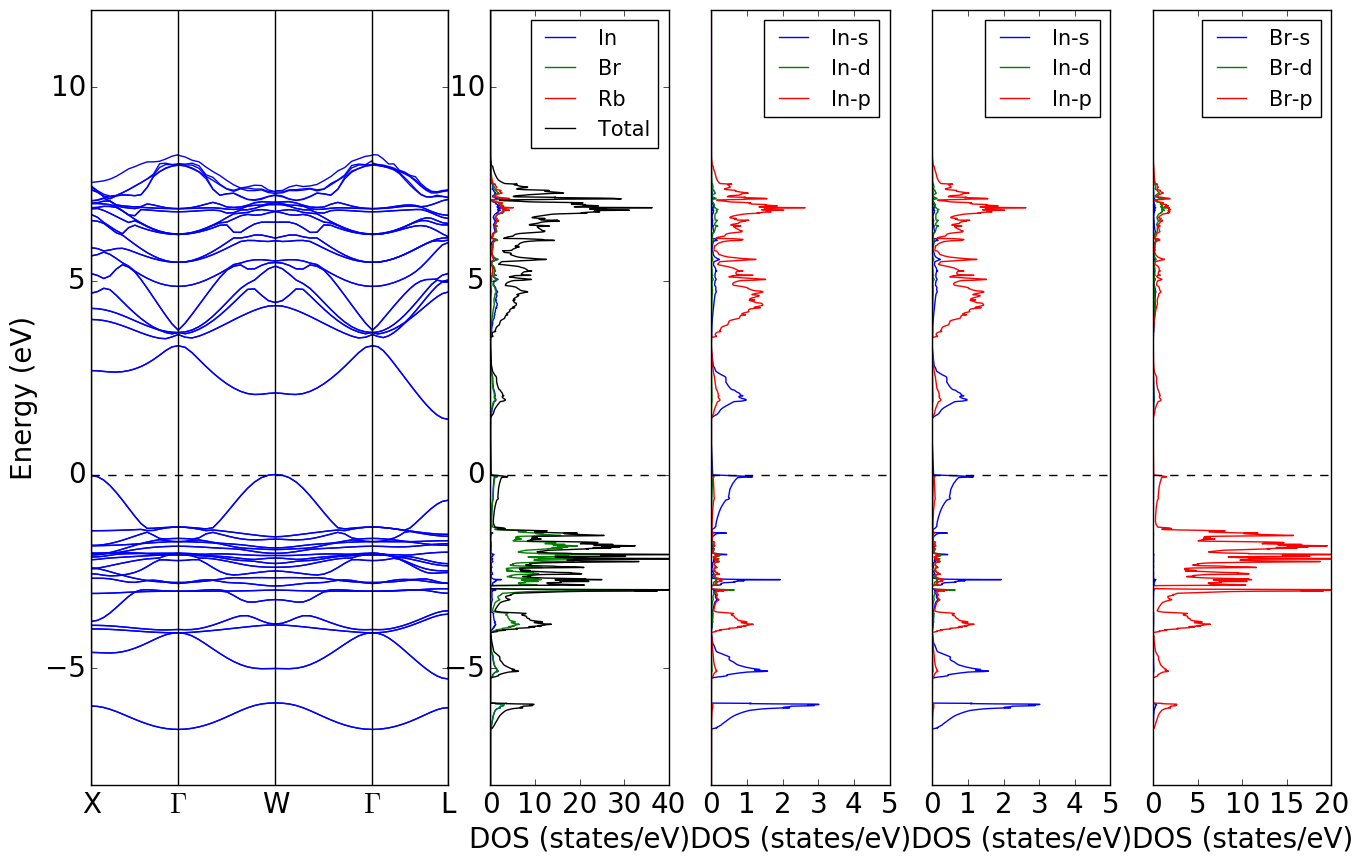

In [57]:
cs = ['Cs2Ag1In1Br6', 'Cs2In1Bi1Cl6', 'Cs2Ag1Sb1I6', 'Cs2Au1Sc1I6', 'Rb2In1In1Br6']

scissor_file = '/Users/yao/Google Drive/data/2116/data/scissor'
scissor_dict = {}
with open(scissor_file, 'r') as f:
    for line in f:
        scissor_dict[line.split()[0]] = float(line.split()[1])
        
c = 'Rb2In1In1Br6'
scissor =  scissor_dict[c]

############################################
fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(1, 5, width_ratios=[2, 1, 1, 1, 1]) 

ax = plt.subplot(gs[0])

#ax.text(-0.2, 1, 'a', fontsize=40, transform=ax.transAxes)
ylim = [-8, 12]
v = Vasprun("/Users/yao/Google Drive/data/2116/PBE_SOC_BS/"+c+"/vasprun.xml")  #####
bs = v.get_band_structure(line_mode=True)
draw_bands(bs, ylim)

v = Vasprun("/Users/yao/Google Drive/data/2116/PBE_SOC/"+c+"/vasprun.xml")
plt.subplot(gs[1])
draw_total_dos(v, [0, 40], ylim, scissor)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ele_list = re.split('1|2|6', c)
A, B1, B2, X = ele_list[0], ele_list[1], ele_list[2], ele_list[3]

plt.subplot(gs[2])
draw_pdos(v, B1, [0, 5], ylim, scissor)

plt.subplot(gs[3])
draw_pdos(v, B2, [0, 5], ylim, scissor)

plt.subplot(gs[4])
draw_pdos(v, X, [0, 20], ylim, scissor)


#plt.savefig('/Users/yao/Google Drive/data/2116/2116 figure/BS_DOS/'+c+'_PBE_SOC_scissor.pdf',dpi=300, bbox_inches='tight')
plt.show()


In [56]:
def add_delete_nbands(nbands, bands):
    nbands_2 = bands.shape[0]
    if nbands_2 < nbands:
        bands = np.concatenate((bands, np.ones((nbands-nbands_2, bands.shape[1]))*100))
    if nbands_2 > nbands:
        bands = bands[nbands, :]
    return bands